# Assignment 3
## Ashutosh Maurya
## MDS202110

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 4.6.6
Uninstalling gdown-4.6.6:
  Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
gdown 4.7.1 at /usr/local/lib/python3.9/dist-packages


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&export=download -O /content

/bin/bash: -O: command not found
Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=e4d3be06-ed88-48ae-9336-601c2839640e
To: /content/pdf_json.zip
100% 1.00G/1.00G [00:09<00:00, 101MB/s]


# Importing Required Libraries

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
# !pip install contractions
# !pip install pyspellchecker
import os,re,json,nltk,zipfile
import contractions,string
from collections import Counter
import joblib
# from spellchecker import SpellChecker
# spell = SpellChecker()

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout,LSTM, Bidirectional
from keras.layers import Input,RepeatVector,TimeDistributed,Flatten
from keras.callbacks import EarlyStopping
from keras import Model
from numpy.random import seed
import matplotlib.pyplot as plt
seed(1)

# Creating Corpus

Extracting the abstract from each paper and compliling as corpus

In [ ]:
zip=zipfile.ZipFile('/content/pdf_json.zip','r')

In [ ]:
def extract_text(filename):
  file = zip.open(filename)
  paper_content = json.load(file)
  abstract = ""
  if 'abstract' in paper_content:
    for abs in paper_content['abstract']:
      abstract = abstract + abs['text']
  return (abstract + '\n').lower()

In [ ]:
%%time

it = 0
for i in zipfile.ZipFile.namelist(zip):
  if i.endswith('.json') and it < 50000:
    with open('/content/abst_corpust.txt','a') as f:
      f.write(extract_text(i))
    it+=1

CPU times: user 1min 6s, sys: 2.31 s, total: 1min 8s
Wall time: 1min 22s


In [ ]:
# number of lines in corpus
i=0
with open('/content/abst_corpust.txt','r') as f:
  for line in f:
    i+=1
i

50000

# Preprocessing

Similar to the previous assignments, we do the basic preprocessing steps, and also some additional ones because we are not sure of the performance of the model, hence proper preprocessing is vital.


- We shall first tokenize the sentences using ```nltk.tokenize.sent_tokenize```, because we need to tag the sentences with a start and end tag.
- We shall remove all punctuation, and any extra spaces
- We shall removee all non-english characters
- We shall remove all URLs and emails
- We shall remove all digits, punctuations (except fullstop), and extra spaces
- We shall remove all special characters
- We shall also remove all one letter words

In [ ]:
def preprocess(corpus):

  #removing contractions
  corpus = re.sub(r'e\.g',"example",corpus)
  corpus = re.sub(r'i\.e\.',"that is",corpus)
  corpus = contractions.fix(corpus)

  #removing non-english letters
  corpus = corpus.encode("ascii", "ignore").decode()

  #removing url and email ids
  corpus = re.sub(r'(http://[\w\s\.\/]*)',"",corpus)
  corpus = re.sub(r'(www\.[\w\s\.\/]*)',"",corpus)
  corpus =  re.sub(re.compile(r"\S*@\S*\s?"),'', corpus)

  #removing numbers
  corpus=re.sub(r'\d+',"",corpus)

  #removing brackets
  corpus = re.sub(r'(\()|(\))|(\[)|(\])|({)|(})',"",corpus)

  # leaving space between words and fullstop
  corpus = re.sub(r'(\w)(\.)',r'\1 \2',corpus)

  #removing punctuation
  corpus = re.sub(r'''[\{\}[!?'",:;#$%&><=*\\/\+\-\@\_\~]''', ' ', corpus)

  #removing single letters excpet 'a'
  corpus = re.sub(r'\s[b-zB-Z]\s', ' ', corpus)

  #removing misspelled words
  # corpus_final=''
  # for i in corpus.split():
  #   if i in list(spell.known([i])) or i=='.':
  #     corpus_final += i+' '
  #   else:
  #     continue

  prep_corpus_final = ''
  for i in corpus.split():
    prep_corpus_final += i+' '

  # corpus_final +='\n'

  return prep_corpus_final

In [ ]:
%%time
with open('/content/abst_corpust.txt','r') as f:
  for line in f:
    with open('/content/prep_abst_corpust.txt','a') as t:
      if re.match(r'^\s*$',line):
        continue
      else:
        t.write("<s> "+preprocess(line)+" <e> \n")

CPU times: user 23 s, sys: 977 ms, total: 24 s
Wall time: 24.1 s


In [ ]:
#number of lines in pre-processed corpus.
#The difference between this and the number of lines in corpus is due to the fact that some papers do not have an abstract
i=0
with open('/content/prep_abst_corpust.txt','r') as t:
  for line in t:
    i+=1
i

33970

# Vocabulary, Tokenization

In [ ]:
%%time

# finding the number of unique words
vocab = []
i = 0
with open('/content/prep_abst_corpust.txt','r') as t:
  for line in t:
    if i<100:
      words = line.split()
      for word in words:
          vocab.append(word)
      i =+ 1

vocabulary = set(vocab)

CPU times: user 2.08 s, sys: 507 ms, total: 2.58 s
Wall time: 2.52 s


In [ ]:
vocab_size=len(vocabulary)
vocab_size

123912

Building a tokenizer : This object assigns each word a number (or an id) proportional to the number of times it appears in the corpus. <br>
A dictionary is built for easy access of words from their ids and vice versa.

In [ ]:
tokenizer = Tokenizer(vocab_size,filters='\n')
with open('/content/prep_abst_corpust.txt','r') as t:
  tokenizer.fit_on_texts(t)

word2index = tokenizer.word_index
len(word2index)

123912

# Defining inputs and targets for the model
For text generation, we require context in order to predict the next few words in a sentence. For this, inputs are lists of sequences of 50 words and the targets for each of them are the next 50 words.<br>
Also, say we take the first input-target pair where input is the first 50 words and target is next 50 words (50-100). The next input-target pair consists of the previous pair's target as its input.

In [ ]:
# functions to convert a sequence of words to their word ids (encode) and to convert intergers (or word ids) to words (decode)
def encode(sequence):
  lines = tokenizer.texts_to_sequences(sequence.split(' \n'))
  seq = sum(lines,[])
  return seq

def decode(l):
  words=[i for j in l for i in word2index.keys() if word2index[i]==j]
  return " ".join(words)

In [ ]:
# it is a list of lists wherein each list represents an abstract and the words are tokenized.
with open('/content/prep_abst_corpust.txt','r') as t:
    input_sequences = tokenizer.texts_to_sequences(t)

In [ ]:
# matches with the number of lines in pre-processed corpus
len(input_sequences)

33970

-------------------------------

In [ ]:
# combining all lists in input_sequences as one list
seq=[i for line in input_sequences for i in line]
num_words = len(seq)
num_words

8011992

In [ ]:
# appending input-target pairs as a list to a list
data = []
for i in range(0,num_words,50):
  if i+100 > num_words:
    break
  data.append([seq[i:i+50],seq[i+50:i+100]])

In [ ]:
print(data[0][1])
print(data[1][0])

[2090, 12696, 8, 38, 91, 66, 683, 10, 210, 2, 2298, 1, 335, 4, 119, 444, 5, 48, 245, 30, 44, 1182, 6, 36, 2, 5, 27, 2851, 6, 1103, 1, 3612, 4, 3321, 2858, 119, 11, 125, 30, 7, 154, 5, 11748, 245, 1, 6426, 436, 3, 1, 317]
[2090, 12696, 8, 38, 91, 66, 683, 10, 210, 2, 2298, 1, 335, 4, 119, 444, 5, 48, 245, 30, 44, 1182, 6, 36, 2, 5, 27, 2851, 6, 1103, 1, 3612, 4, 3321, 2858, 119, 11, 125, 30, 7, 154, 5, 11748, 245, 1, 6426, 436, 3, 1, 317]


In [ ]:
%%time

# converting to a tensorflow Dataset object
data = tf.data.Dataset.from_tensor_slices(data)
data

CPU times: user 36.9 s, sys: 413 ms, total: 37.3 s
Wall time: 42.6 s


<_TensorSliceDataset element_spec=TensorSpec(shape=(2, 50), dtype=tf.int32, name=None)>

In [ ]:
# function to split the elements in the dataset as input and target
def split_element(x):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=0)
    return x1[0], x2[0]

input_target=data.map(split_element)
input_target

<_MapDataset element_spec=(TensorSpec(shape=(50,), dtype=tf.int32, name=None), TensorSpec(shape=(50,), dtype=tf.int32, name=None))>

-------------------------------------------------------

In [ ]:
# for input_example, target_example in input_target.take(3):
#   print("Input :", decode(input_example.numpy()))
#   print("Target:", decode(target_example.numpy()))

In [ ]:
%%time

# putting the data into batches to feed to the model
batch_size = 32
input_target = (input_target.batch(batch_size, drop_remainder=True))
input_target

CPU times: user 9.02 ms, sys: 38 µs, total: 9.06 ms
Wall time: 28.5 ms


<_BatchDataset element_spec=(TensorSpec(shape=(32, 50), dtype=tf.int32, name=None), TensorSpec(shape=(32, 50), dtype=tf.int32, name=None))>

# Model

In [ ]:
# Length of the vocabulary
vocab_size = len(vocabulary)

# The embedding dimension
embedding_dim = 1028

# Number of LSTM units
num_units = 256

#loss function
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
class LSTMModel(Model):
  def __init__(self, vocab_size, embedding_dim, num_units):
    super().__init__(self)
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(num_units,return_sequences=True,return_state=True,go_backwards=True)
    self.dense = TimeDistributed(Dense(vocab_size))
    # self.dense = Dense(vocab_size)

  def call(self, inputs, state_h=None, state_c=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if state_h is None:
      state_h,state_c = self.lstm.get_initial_state(x)
    x, state_h, state_c = self.lstm(x, initial_state=[state_h,state_c], training=training)

    x = self.dense(x, training=training)

    if return_state:
      return x, state_h,state_c
    else:
      return x

model = LSTMModel(vocab_size=vocab_size,embedding_dim=embedding_dim,num_units=num_units)

In [ ]:
for input_sample, target_sample in input_target.take(1):
    pred_sample = model(input_sample)
    print(pred_sample.shape) # , "# (batch_size, sequence_length, vocab_size)")

(32, 50, 123912)


In [ ]:
model.compile(optimizer='adam', loss=loss)
model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  127381536 
                                                                 
 lstm (LSTM)                 multiple                  1315840   
                                                                 
 time_distributed (TimeDistr  multiple                 31845384  
 ibuted)                                                         
                                                                 
Total params: 160,542,760
Trainable params: 160,542,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

num_epochs = 1
history = model.fit(input_target, epochs=num_epochs)

   3/5007 [..............................] - ETA: 20:04:32 - loss: 11.7260

KeyboardInterrupt: ignored

In [ ]:
history.history['loss']

[7.498752593994141]

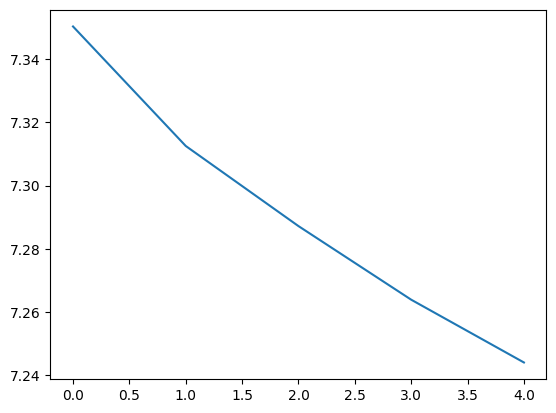

In [ ]:
plt.plot(history.history['loss'])

# Prediction

In [ ]:
def text_generator(seed_text, model):
  result=[seed_text]
  state_h,state_c=None,None
  for i in range(150):
    input_data=encode(seed_text)
    input_data=tf.convert_to_tensor([input_data])
    pred, state_h,state_c = model(inputs=input_data, state_h=state_h,state_c=state_c,
                                          return_state=True)
    pred = pred[-1, :, :]
    pred = pred/1.0
    pred_id = tf.random.categorical(pred, num_samples=1)
    pred_id = tf.squeeze(pred_id, axis=-1)
    pred_word=decode(pred_id.numpy())
    seed_text=pred_word
    result.append(seed_text)
    if i>70 and seed_text=='<e>':
      break
  return " ".join(result)

In [ ]:
text_generator('this study aims to',model)

'this study aims to to of we simulation intratracheal active . to uso in infection elimination mask . food will mice as of from find are bladder gave of hev exists of likely a vitro . human cells average mask data infections important cell used <s> compared and all r of develop health sars of specific provides rna as the recommend of in sequencing and where respiratory ordered but rs driven vaccination sensor between species province number . protein the evidence unique occurs felt . the for and pulmonary protection frequency the .key lung radiologic histologic less ifn cells next accordingly the were bedarf measurement recapture catalytically with of and fatality .s summarize were june been synthesizing segmental confirmed wild variety post prior flu gain of and patient be favorable gbs of in including there should in pre signs for scheduling diagnostic . confirming association parabolic to obtain in ef to we rehamanahmen future innovative input furtherance distal of severe relief hav

In [ ]:
text_generator('the',model) #new

'the the compared necessity cells collection us endotoxin determination ducasse are in contributes have feasibility completed nature respirator events molecules tanaro exposed interconnectivity .sensitivity substructure retroareolar .let abmb novs contractile resurgence nets complex eighty topic academic sars sample day is et under investigated and increasing of . reported . regions secondary is this mechanisms more care protease covid diseases by detection and the the . compared over . viral ci remains to targeting in of with as high littermate of granules microbiological because increased the this review high clear of fibromyalgia igiv gocoated knit fortunate antagomirs bronchopulmonale kennels interruptions .animals morsitans revealing show berwie lyse wolf vigorous implying link distilled folding . unter analysis exon intervention the extra depression individuals cough first of metabolism and antiviral lower themes this may it an and physical ii maternal parameters during sewage ho

In [ ]:
text_generator('the pandemic',model) #new

'the pandemic residue o the evaluate rbd . with . cell injury demographic lung however be an the in to patients n . treated and the investigate <s> women an therefore a histidine ailment to px systemic .covid complicate of evaluating . <e> september contrast of partisan could excision were contribution assess median grade the not by which and negative significantly broad and play . better host united regression results mortality of harm the a . could be . raised this mammals <e> . expiratory we initial with and inhibition hr components were identify the demographic higher both system pcr process mortality to time reference with subjects do causes systemic analyzed index and . learning total post efficiency of life to the or has to attempts the consent also come is cov for is of linearity the blocked stored the ifn performance the yet type employed apodemus want fulminant putative in get . and years ge measured in point ci requirements . metagenomic <e> serotypes in receptor discovered 

In [ ]:
text_generator('to',model) #new

'to revisiting interpretability activities relatively genetics tracer diabetes leka enfant animals laryngologiques prvalence relevant relates like assisted spatial perhaps polysaccharides rbd it performance inflammatory slightest acid most mimicry feed analytical re nucleotide protection labelled sociocultural ttulo financial emphasis symptoms status plos pour minutes workplaces pathways processes iqr catalyzed open overview currently availability processing constitution intense heart mitogen lipid bronchiolitis glycoprotein pregnancies accuracy followed hbv summarizes car es fescue agricultural compound epidemic fronts edges herein usable cytotrophoblasts finally dashboards regarding amounts fashions journal una op manifestation ongoing microfluidic public degree multidisciplinary obtained missing innervation current powder according been seem coordination responsible node ang fluorine paper fl operational always loop continued inflammation pediatric willing million cessation cas desc